# Predikere RSRP

### Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
from time import time

In [12]:
def read_dataset(filename, campaign=None):
    df = pd.read_csv(filename)
    df = df.loc[:, ~df.columns.str.match('Unnamed')]
    df = df.loc[:, ~df.columns.str.match('Timestamp')]
    df = df.replace('DC', 1)
    df = df.replace('LTE', 0)
    df = df[df['campaign'].str.contains('Driving')]

    if campaign != None:
        df = df[df['campaign'] == campaign]

    df, mode = df[['RSRP', 'SSS_RSRP', 'campaign']], df['Mode']
    return df, mode

def series_split_sequences(f, n_steps_in, n_steps_out):
    X, y = [], []
    curr_campaign = ''
    for i in range(len(f)):
        # find the end of the pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        if out_end_ix > len(f): # check to see if we are bwyond the data set
            break

        if curr_campaign == '': # set new current campaign if there is np campaign
            curr_campaign = f['campaign'].iloc[i]
        seq_x, seq_y = f[i:end_ix], f[end_ix:out_end_ix][['RSRP', 'SSS_RSRP']]
        if f.iloc[i:out_end_ix]['campaign'].nunique() > 1: # check to see if in transition between two campaigns
            continue
        elif curr_campaign != f['campaign'].iloc[i]: # set new campaign equal to current if this is the campaign we are looping through
            curr_campaign = f['campaign'].iloc[i]
        X.append(seq_x.drop('campaign', axis=1))
        y.append(seq_y)
    return np.array(X), np.array(y)

In [13]:
campaign='Interactivity_gaming_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode'
df, mode = read_dataset('datasets/Op1_merged.csv', campaign=campaign)

n_steps_in, n_steps_out = 15, 1
X, y = series_split_sequences(df, n_steps_in, n_steps_out)

train_size = len(y) // 3 * 2
test_size = (len(y) - train_size) // 2 + train_size

X_train, y_train = X[0 : train_size], y[0 : train_size]
X_val, y_val = X[train_size : test_size], y[train_size : test_size]
X_test, y_test = X[test_size ::], y[test_size ::]

n_features = X_train.shape[2]

In [32]:
model = Sequential()
model.add(LSTM(input_shape=(n_steps_in, n_features), units=100,
               activation='relu', recurrent_activation='sigmoid',
               return_sequences=True, return_state=False
              ))
model.add(LSTM(units=100,
               activation='relu', recurrent_activation='sigmoid',
               return_sequences=False, return_state=False
              ))
model.add(Dense(n_steps_out, activation='softmax'))
model.compile(loss='mse',
              metrics=['accuracy'],
              optimizer='adam')

In [33]:
start = time()
History = model.fit(X_train, y_train,
                    epochs=100,
                    validation_data=(X_val, y_val),
                    shuffle=True, verbose=0)
print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)

-----------------------------------------------------------------
Training was completed in 171.09 secs
-----------------------------------------------------------------


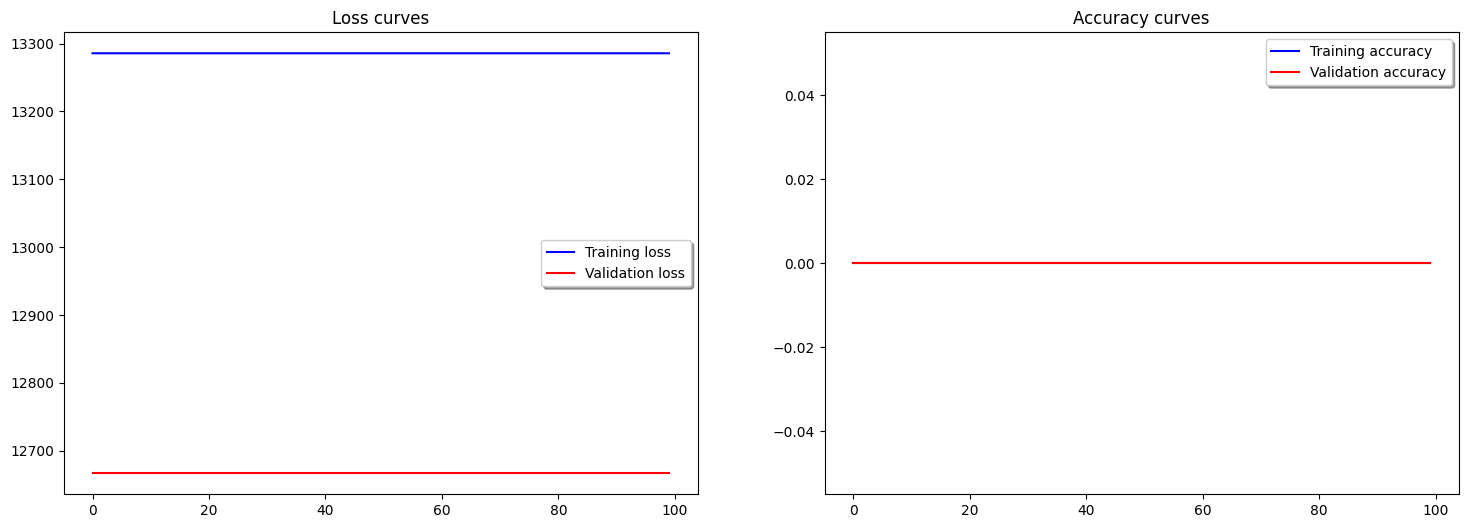

In [28]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [30]:
y_pred = model.predict(X_test)
print(y_pred)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
